# $|\psi_{ab}\rangle$ states tests
This Jupyter Notebook is used to carry out the dynamical decoupling tests with the $|\psi_{ab}\rangle$ (two-qubit) states and the three simple universal sequences XYXY, XZXZ and YZYZ (and free evolution IIII).

The $|\psi_{ab}\rangle$ states have the form $|\psi_{ab}\rangle=a|10\rangle+b|01\rangle$ , where $a$ and $b$ are real parameters that satisfy $a^2+b^2=1$ and where we considered Qiskit's ket qubit ordering notation ($|qubit\, 4, qubit\, 3\rangle$, little-endian ordering).

### Load the libraries

In [1]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile, schedule, transpiler
from qiskit import IBMQ
from qiskit.tools.jupyter import *
from qiskit.tools import job_monitor
from qiskit.providers.ibmq.managed import IBMQJobManager

import numpy as np
import matplotlib.pyplot as plt

# For data fitting
from lmfit import Model

# For contour smoothing with cubic spline interpolation. https://stackoverflow.com/questions/12274529/how-to-smooth-matplotlib-contour-plot
import scipy.ndimage

# https://matplotlib.org/stable/gallery/misc/patheffect_demo.html
from matplotlib import patheffects

### Get the provider with your account id and set the backend (ibmq_lima)

In [2]:
provider = IBMQ.enable_account('your-ibmq-id-here')

In [3]:
backend = provider.get_backend('ibmq_lima')

### Get information about the duration of some of the instructions of the backend

In [4]:
# Get duration of instructions
dt_in_s = backend.configuration().dt
Reset_duration = transpiler.InstructionDurations.from_backend(backend).get("reset",4)
I_duration     = transpiler.InstructionDurations.from_backend(backend).get("id",4)
Z_duration     = transpiler.InstructionDurations.from_backend(backend).get("rz",4)
SX_duration    = transpiler.InstructionDurations.from_backend(backend).get("sx",4)
X_duration     = transpiler.InstructionDurations.from_backend(backend).get("x",4)
Y_duration     = 3*Z_duration + 2*SX_duration
H_duration     = 2*Z_duration + SX_duration
Measurement_duration = transpiler.InstructionDurations.from_backend(backend).get("measure",4)

### Define the functions for obtaining the $b$ and $\theta$ parameters from $a$

$$a\in [0,\,1]\mbox{ (positive $a$ case)}\quad \mbox{or}\quad a\in[-1,\,0]\mbox{ (negative $a$ case)}$$

$$a^2+b^2=1 \longrightarrow b = \sqrt{1-a^2}$$

$$a = \cos\left(\frac{\theta}{2}\right) \longrightarrow \theta = 2 \arccos(a)$$

In [5]:
def b(a):
    return np.sqrt(1-a**2)

def theta(a):
    return 2*np.arccos(a)

### Define the function that generates the circuits

In [6]:
def get_transpiled_circuit(num_blocks, backend, 
                           X_duration, Y_duration, dt_in_s,
                           a_value=1/(2**0.5), dynamicalDecoupling=True, sequence="XYXY"): 

    """
    a_value: a float
    dynamicalDecoupling: True, False
    sequence: "XYXY", "XZXZ", "YZYZ"
    qubits used -> qubit 3 and qubit 4
    
    The main circuit is divided into subcircuits: data preparation, dynamical decoupling, inverse of data preparation, measurement.
    """
    
    # Duration of the 4-gate blocks of the sequences (the duration of a Z gate is 0)
    tau_block = {"XYXY":2*(X_duration+Y_duration),
                 "XZXZ":2*X_duration,
                 "YZYZ":2*Y_duration}
    
    # Data preparation subcircuit
    dataCircuit = QuantumCircuit(5, 2)
    dataCircuit.x(4)
    dataCircuit.ry(theta(a_value), 3)
    dataCircuit.cnot(3,4)
    dataCircuit = transpile(dataCircuit, backend=backend, scheduling_method='alap', optimization_level=0)
    
    # Dynamical decoupling sequence subcircuit
    ddCircuit = QuantumCircuit(5, 2)
    # Apply dynamical decoupling or wait
    if dynamicalDecoupling == True:   
        for i in range(num_blocks): # Put the sequence 4-gate blocks on both qubits
            if sequence == "XYXY":
                ddCircuit.x([3,4])
                ddCircuit.y([3,4])
                ddCircuit.x([3,4])
                ddCircuit.y([3,4])
            elif sequence == "XZXZ":
                ddCircuit.x([3,4])
                ddCircuit.z([3,4])
                ddCircuit.x([3,4])
                ddCircuit.z([3,4])
            elif sequence == "YZYZ":
                ddCircuit.y([3,4])
                ddCircuit.z([3,4])
                ddCircuit.y([3,4])
                ddCircuit.z([3,4])
    elif dynamicalDecoupling == False:
        # Set the number of identity gates in a free evolution block 
        # so that it has the same duration as the block from the 
        # corresponding dynamical decoupling sequence
        num_ids = {"XYXY":6, "XZXZ":2, "YZYZ":4}
        # Build the free evolution part.
        for i in range(num_blocks): # Put the identity gate blocks of the free evolution
            for j in range(num_ids[sequence]):
                ddCircuit.id([3,4]) # How a single block is built
    # Transpile the dynamical decoupling subcircuit
    ddCircuit = transpile(ddCircuit, backend=backend, scheduling_method='alap', optimization_level=0)
    
    tau_wait  = num_blocks*tau_block[sequence] # Duration of the dynamical decoupling sequence
    wait_duration = tau_wait*dt_in_s*1e6 # Convert the duration from system units (dt) to microseconds
    
    # Measuerement subcircuit
    measCircuit = QuantumCircuit(5, 2)
    measCircuit.measure(3,0)
    measCircuit.measure(4,1)
    measCircuit = transpile(measCircuit, backend=backend, scheduling_method='alap', optimization_level=0)
    
    # Build the main circuit including the decoding of the data state back to |00> (dataCircuit.inverse())
    transpiled_circuit = dataCircuit + ddCircuit + dataCircuit.inverse()

    # Include the measurements in the circuit
    transpiled_circuit = transpiled_circuit + measCircuit
    transpiled_circuit = transpile(transpiled_circuit, backend=backend, scheduling_method='alap', optimization_level=0)
    
    return transpiled_circuit, wait_duration

### Parameters for creating the tests circuits

Select the positive or negative $a$ array depending on the case.

In [83]:
max_time   = 15 # In microseconds.
num_steps  = 30
wait_times = np.linspace(0, max_time, num_steps)  # In microseconds.

num_blocks_array    = ((wait_times*1e-6/dt_in_s)/(2*(X_duration + Y_duration))).astype(int) # Number of blocks necessary to fit the wait times.
num_blocks_array_XY = ((wait_times*1e-6/dt_in_s)/(2*(X_duration + Y_duration))).astype(int) # For the XYXY case
num_blocks_array_XZ = ((wait_times*1e-6/dt_in_s)/(2*X_duration)).astype(int)                # For the XZXZ case
num_blocks_array_YZ = ((wait_times*1e-6/dt_in_s)/(2*Y_duration)).astype(int)                # For the YZYZ case

shots = 2**13 # 2**13, 8192

repetitions = 10
num_sequences = 4

######## POSITIVE a CASE ########
a = np.linspace(0, 1, num_steps)
#################################

######## NEGATIVE a CASE ########
#a = np.linspace(0, -1, num_steps)
#################################

reshape_dims = (len(a), repetitions, num_sequences, num_steps)
#print(reshape_dims)
#print("Total number of circuits:", np.prod(reshape_dims))
#print("Number of job batches to be sent:", int(np.prod(reshape_dims)/100)+1)

### Build the circuits

In [ ]:
all_wait_times = []
all_transpiled_circuits = []

"""
Data format: [[[XYXY case, XZXZ case, YZYZ case, IIII case], repetitions...] for a[0],
              [[XYXY case, XZXZ case, YZYZ case, IIII case], repetitions...] for a[1],
              ...
              [[XYXY case, XZXZ case, YZYZ case, IIII case], repetitions...] for a[-1]]
"""

for i, a_value in enumerate(a):
    
    wait_times_XYXY = []
    wait_times_XZXZ = []
    wait_times_YZYZ = []
    wait_times_IIII = []
    transpiled_circuits_XYXY = []
    transpiled_circuits_XZXZ = []
    transpiled_circuits_YZYZ = []
    transpiled_circuits_IIII = []
    
    state_transpiled_circuits = []
    
    print("a value:", a_value)
    #print("Generating the XYXY circuits...")
    for j, num_blocks in enumerate(num_blocks_array_XY): # Build the XYXY circuits.
        #print("\tXYXY", i, j+1, num_steps)
        tcircuit, wait_time = get_transpiled_circuit(num_blocks, backend, 
                                                     X_duration, Y_duration, dt_in_s,
                                                     a_value=a_value, dynamicalDecoupling=True, sequence="XYXY")
        wait_times_XYXY.append(wait_time)
        transpiled_circuits_XYXY.append(tcircuit)
    
    #print("Generating the XZXZ circuits...")
    for j, num_blocks in enumerate(num_blocks_array_XZ): # Build the XZXZ circuits.
        #print("\tXZXZ", i, j+1, num_steps)
        tcircuit, wait_time = get_transpiled_circuit(num_blocks, backend, 
                                                     X_duration, Y_duration, dt_in_s,
                                                     a_value=a_value, dynamicalDecoupling=True, sequence="XZXZ")
        wait_times_XZXZ.append(wait_time)
        transpiled_circuits_XZXZ.append(tcircuit)
    
    #print("Generating the YZYZ circuits...")
    for j, num_blocks in enumerate(num_blocks_array_YZ): # Build the YZYZ circuits.
        #print("\tYZYZ", i, j+1, num_steps)
        tcircuit, wait_time = get_transpiled_circuit(num_blocks, backend, 
                                                     X_duration, Y_duration, dt_in_s,
                                                     a_value=a_value, dynamicalDecoupling=True, sequence="YZYZ")
        wait_times_YZYZ.append(wait_time)
        transpiled_circuits_YZYZ.append(tcircuit)
        
    #print("Generating the IIII circuits...")
    for j, num_blocks in enumerate(num_blocks_array): # Build the IIII circuits.
        #print("\tIIII", i, j+1, num_steps)
        tcircuit, wait_time = get_transpiled_circuit(num_blocks, backend, 
                                                     X_duration, Y_duration, dt_in_s,
                                                     a_value=a_value, dynamicalDecoupling=False)
        wait_times_IIII.append(wait_time)
        transpiled_circuits_IIII.append(tcircuit)
        
    state_transpiled_circuits.append([transpiled_circuits_XYXY, transpiled_circuits_XZXZ, transpiled_circuits_YZYZ, transpiled_circuits_IIII])
    all_wait_times.append([wait_times_XYXY, wait_times_XZXZ, wait_times_YZYZ, wait_times_IIII])
    
    # Flatten the transpiled circuits to send them in a single job
    circuits_array = np.asarray(state_transpiled_circuits) # Get a 2D array containing the set of circuits for each sequence.
    dimensions = np.shape(circuits_array) # Get the dimensions of the 2D array.
    circuits_array_flattened = circuits_array.flatten() # Make the array 1-dimensional.
    
    #print("Building repetitions...")
    for j in range(repetitions):
        #print("\tRepetition",j)
        all_transpiled_circuits = all_transpiled_circuits + circuits_array_flattened.tolist()
        
    print("Done!")
print("Finished!")

### Send the job to IBMQ (...)

In [ ]:
job_manager = IBMQJobManager()
job_set = job_manager.run(all_transpiled_circuits, backend=backend, name='TwoQubitStatesPsiab-8192shots-15us-30steps-10reps-q3q4', shots=shots)

Print the id of the job set for being able to retrieve it in the future.

In [ ]:
job_set_id = job_set.job_set_id()
print(job_set_id)

For checking the progress of the jobs:

In [ ]:
statuses = job_set.statuses()
total = len(statuses)
done = 0

for status in statuses:
    if status.name == "DONE":
        done += 1
            
print(f"{done}/{total} jobs done.")
statuses

Get the results.

In [ ]:
results = job_set.results()

Get the counts from the results.

In [ ]:
all_counts_array = np.array([results.get_counts(i) for i in range(len(all_transpiled_circuits))])

### (...) or get the data shown in the paper

For the positive $a$ case:

In [85]:
all_counts_array = np.load("all_counts_array-positive_ab_Landscape-15us_30steps_10reps_4seqs_Q3Q4.npy", allow_pickle=True)

For the negative $a$ case:

In [54]:
all_counts_array = np.load("all_counts_array-negative_ab_Landscape-15us_30steps_10reps_4seqs_Q3Q4.npy", allow_pickle=True)

### Reshape the counts to facilitate working with them

In [ ]:
"""
Data format: [[[XYXY case, XZXZ case, YZYZ case, IIII case], repetitions...] for a[0],
              [[XYXY case, XZXZ case, YZYZ case, IIII case], repetitions...] for a[1],
              ...
              [[XYXY case, XZXZ case, YZYZ case, IIII case], repetitions...] for a[-1]]
            
reshape_dims = (number of states considered, repetitions, number of sequences, number of time steps) = (30, 10, 4, 30)
"""

reshaped_counts = all_counts_array.reshape(reshape_dims)
reshaped_counts

### Extract the data

Define a funtion for converting counts to fidelity

In [56]:
def get_fidelity_data(sequence, a, reshaped_counts, repetitions, shots, num_steps):
    
    # Initialize storage lists
    F = []
    F_err = []
    
    for ai in a:
        # Get the index corresponding to where ai is located in a
        i = int(np.where(a==ai)[0])
        # Get probability of measuring |00> at the end
        probs_00 = np.asarray([[reshaped_counts[i][k][sequence][j]["00"] for j in range(num_steps)] for k in range(repetitions)])/shots
        # Average the repetitions
        avg_probs_00 = np.average(probs_00, axis=0)
        # Get the error amplitude as the difference between the maximum and minimum value obtained with the repetitions (like the amplitude of the error bars)
        error_amplitude_00 = np.max(probs_00, axis=0) - np.min(probs_00, axis=0)

        # Get the fidelity as the average survival probabilities
        fidelity = avg_probs_00
        # Get the fidelity error amplitudes as the error amplitudes of the survival probabilities
        error_amp_fidelity = error_amplitude_00

        # Store in a list
        F.append(fidelity)
        F_err.append(error_amp_fidelity)
        
    return F, F_err

### Plot the results

#### Use this cell for the positive $a$ case

C:\Users\usuario\AppData\Local\Temp\ipykernel_49372\2482435375.py:70: UserWarning: No contour levels were found within the data range.
  ct_white = ax2.contour(a_interpolated, wait_times_interpolated, F_err_interpolated, colors="w", alpha=0.8, linewidths=4, levels=[0.0, 0.1, 0.2, 0.4])
C:\Users\usuario\AppData\Local\Temp\ipykernel_49372\2482435375.py:71: UserWarning: No contour levels were found within the data range.
  ct = ax2.contour(a_interpolated, wait_times_interpolated, F_err_interpolated, colors="k", alpha=1, linewidths=1, levels=[0.0, 0.1, 0.2, 0.4])


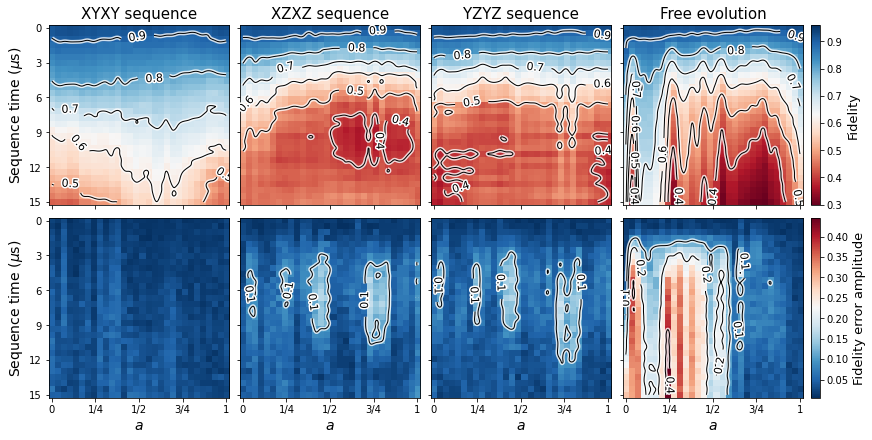

In [88]:
# Get colormap limits

# Check the current case data (positive a)
# Limits of the fidelity plots
vmax = np.max([get_fidelity_data(sequence, a, reshaped_counts, repetitions, shots, num_steps)[0] for sequence in range(4)])
vmin = np.min([get_fidelity_data(sequence, a, reshaped_counts, repetitions, shots, num_steps)[0] for sequence in range(4)])
# Limits of the error amplitude plots
vmax_err = np.max([get_fidelity_data(sequence, a, reshaped_counts, repetitions, shots, num_steps)[1] for sequence in range(4)])
vmin_err = np.min([get_fidelity_data(sequence, a, reshaped_counts, repetitions, shots, num_steps)[1] for sequence in range(4)])
# Print the current limits
#print(vmin, vmax)
#print(vmin_err, vmax_err)

# Compare limits from both cases:
#vmin, vmax = 0.29893798828125, 0.9278564453125 # From the positive a case
#vmin, vmax = 0.34295654296875, 0.9607666015625 # From the negative a case
#vmin_err, vmax_err = 0.0052490234375, 0.4462890625 # From the positive a case
#vmin_err, vmax_err = 0.0030517578125, 0.1575927734375 # From the negative a case

# From both cases use the maximum and minimum values as limits equal for both cases
vmin, vmax = 0.29893798828125, 0.9607666015625 # vmin from a>0, vmax from a<0
# Fidelity error amplitude colormap limits
vmin_err, vmax_err = 0.0052490234375, 0.4462890625 # # Both vmin_err and vmax_err from a<0


# Initialize the figure and the axes
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(12,6), constrained_layout=True, sharex=True, sharey=True)

# Font sizes
title_fs = 15
labels_fs = 14
cbars_fs = 13
ticks_fs = 10

times = np.arange(0, 15+1, 3) # For the axis ticks
da = a[1]-a[0] # Distance between the different a values
dt = wait_times[1]-wait_times[0] # Time step size
sequence_names = ["XYXY sequence", "XZXZ sequence", "YZYZ sequence", "Free evolution"]

for col in range(4): # For each sequence

    ax  = axs[0][col] # Top row axes
    ax2 = axs[1][col] # Bottom row axes
    ax.set_title(f"{sequence_names[col]}", fontsize=title_fs)
    
    # Get the fidelity data for the corresponding sequence
    F, F_err = get_fidelity_data(col, a, reshaped_counts, repetitions, shots, num_steps) # sequence index = column number (col)
    
    # Plot the 2d data
    myplot  = ax.imshow(np.asarray(F).T, extent=[-da/2,1+da/2,15+dt/2,-dt/2], aspect=1/15, cmap="RdBu", vmin=vmin, vmax=vmax) # bwr_r, seismic_r, gist_heat, terrain_r, twilight_shifted_r
    myplot2 = ax2.imshow(np.asarray(F_err).T, extent=[-da/2,1+da/2,15+dt/2,-dt/2], aspect=1/15, cmap="RdBu_r", vmin=vmin_err, vmax=vmax_err)
    
    # Generate the interpolated data for creating the smooth qualitative contours
    zoom_factor = 8
    F_interpolated = scipy.ndimage.zoom(np.asarray(F).T, zoom_factor)
    F_err_interpolated = scipy.ndimage.zoom(np.asarray(F_err).T, zoom_factor)
    a_interpolated = scipy.ndimage.zoom(a, zoom_factor)
    wait_times_interpolated = scipy.ndimage.zoom(wait_times, zoom_factor)
    
    # Plot the smoothed contours
    # The top row contour lines
    ct_white = ax.contour(a_interpolated, wait_times_interpolated, F_interpolated, colors="w", alpha=0.8, linewidths=4, levels=[0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
    ct = ax.contour(a_interpolated, wait_times_interpolated, F_interpolated, colors="k", alpha=1, linewidths=1, levels=[0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
    # Top row contour labels
    ax.clabel(ct_white, inline=1, fontsize=11)
    clbls = ax.clabel(ct, inline=1, fontsize=11)
    plt.setp(clbls, path_effects=[patheffects.withStroke(linewidth=3, foreground="w")]) # Add white edge to labels
    # The bottom row contour lines
    ct_white = ax2.contour(a_interpolated, wait_times_interpolated, F_err_interpolated, colors="w", alpha=0.8, linewidths=4, levels=[0.0, 0.1, 0.2, 0.4])
    ct = ax2.contour(a_interpolated, wait_times_interpolated, F_err_interpolated, colors="k", alpha=1, linewidths=1, levels=[0.0, 0.1, 0.2, 0.4])
    # Bottom row contour labels
    ax2.clabel(ct_white, inline=1, fontsize=11)
    clbls = ax2.clabel(ct, inline=1, fontsize=11)
    plt.setp(clbls, path_effects=[patheffects.withStroke(linewidth=3, foreground="w")]) # Add white edge to labels

    ax2.set_xlabel("$a$", fontsize=labels_fs)
    
    if col==0:
        ax.set_ylabel("Sequence time ($\\mu$s)", fontsize=labels_fs)
        ax2.set_ylabel("Sequence time ($\\mu$s)", fontsize=labels_fs)

    ax.set_xticks([0,0.25,0.5,0.75,1])
    ax.set_yticks(times)
    ax2.set_xticks([0,0.25,0.5,0.75,1])
    ax2.set_yticks(times)
    ax2.set_xticklabels(["0", "1/4", "1/2", "3/4", "1"])

    ax.tick_params(axis="both", labelsize=ticks_fs)
    ax2.tick_params(axis="both", labelsize=ticks_fs)
    
    # Add common (global) colorbars
    if col == 3:
        cbar  = fig.colorbar(myplot, ax=ax, fraction=0.05, pad=0.04).set_label("Fidelity", size=cbars_fs) #https://stackoverflow.com/a/26720422
        cbar2 = fig.colorbar(myplot2, ax=ax2, fraction=0.05, pad=0.04).set_label("Fidelity error amplitude", size=cbars_fs)
        
#plt.show()
plt.savefig(r"landscapePosTwoQubit.pdf")  

#### Use this cell for the negative $a$ case

C:\Users\usuario\AppData\Local\Temp\ipykernel_49372\2610895152.py:69: UserWarning: No contour levels were found within the data range.
  ct_white = ax2.contour(a_interpolated, wait_times_interpolated, F_err_interpolated, colors="w", alpha=0.8, linewidths=4, levels=[0.0, 0.1, 0.2, 0.4])
C:\Users\usuario\AppData\Local\Temp\ipykernel_49372\2610895152.py:70: UserWarning: No contour levels were found within the data range.
  ct = ax2.contour(a_interpolated, wait_times_interpolated, F_err_interpolated, colors="k", alpha=1, linewidths=1, levels=[0.0, 0.1, 0.2, 0.4])


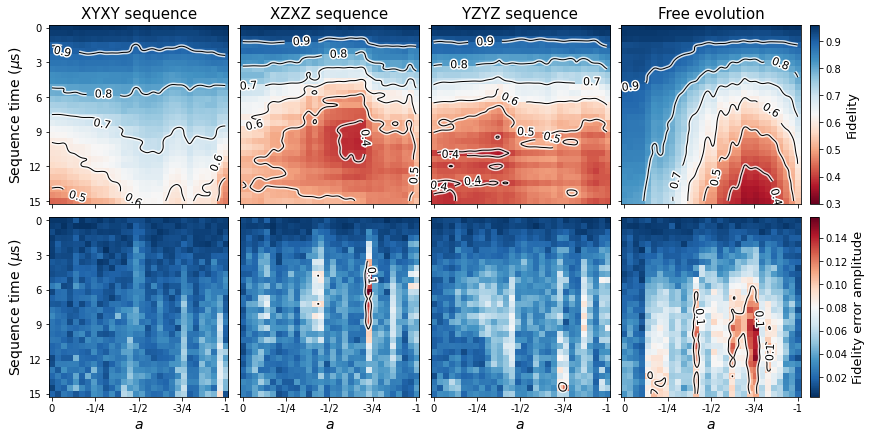

In [82]:
# Get colormap limits

# Check the current case data (positive a)
# Limits of the fidelity plots
vmax = np.max([get_fidelity_data(sequence, a, reshaped_counts, repetitions, shots, num_steps)[0] for sequence in range(4)])
vmin = np.min([get_fidelity_data(sequence, a, reshaped_counts, repetitions, shots, num_steps)[0] for sequence in range(4)])
# Limits of the error amplitude plots
vmax_err = np.max([get_fidelity_data(sequence, a, reshaped_counts, repetitions, shots, num_steps)[1] for sequence in range(4)])
vmin_err = np.min([get_fidelity_data(sequence, a, reshaped_counts, repetitions, shots, num_steps)[1] for sequence in range(4)])
# Print the current limits
#print(vmin, vmax)
#print(vmin_err, vmax_err)

# Compare limits from both cases:
#vmin, vmax = 0.29893798828125, 0.9278564453125 # From the positive a case
#vmin, vmax = 0.34295654296875, 0.9607666015625 # From the negative a case
#vmin_err, vmax_err = 0.0052490234375, 0.4462890625 # From the positive a case
#vmin_err, vmax_err = 0.0030517578125, 0.1575927734375 # From the negative a case

# From both cases use the maximum and minimum values as limits equal for both cases
vmin, vmax = 0.29893798828125, 0.9607666015625 # vmin from a>0, vmax from a<0
# Fidelity error amplitude colormap limits
vmin_err, vmax_err = 0.0030517578125, 0.1575927734375 # Both vmin_err and vmax_err from a<0


# Initialize the figure and the axes
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(12,6), constrained_layout=True, sharex=True, sharey=True)

# Font sizes
title_fs = 15
labels_fs = 14
cbars_fs = 13
ticks_fs = 10

times = np.arange(0, 15+1, 3) # For the axis ticks
da = a[1]-a[0] # Distance between the different a values
dt = wait_times[1]-wait_times[0] # Time step size
sequence_names = ["XYXY sequence", "XZXZ sequence", "YZYZ sequence", "Free evolution"]

for col in range(4): # For each sequence

    ax  = axs[0][col] # Top row axes
    ax2 = axs[1][col] # Bottom row axes
    ax.set_title(f"{sequence_names[col]}", fontsize=title_fs)
    
    # Get the fidelity data for the corresponding sequence
    F, F_err = get_fidelity_data(col, a, reshaped_counts, repetitions, shots, num_steps) # sequence index = column number (col)
    
    # Plot the 2d data
    myplot  = ax.imshow(np.asarray(F).T, extent=[-da/2,-1+da/2,15+dt/2,-dt/2], aspect=1/15, cmap="RdBu", vmin=vmin, vmax=vmax) # bwr_r, seismic_r, gist_heat, terrain_r, twilight_shifted_r
    myplot2 = ax2.imshow(np.asarray(F_err).T, extent=[-da/2,-1+da/2,15+dt/2,-dt/2], aspect=1/15, cmap="RdBu_r", vmin=vmin_err, vmax=vmax_err)
    
    # Generate the interpolated data for creating the smooth qualitative contours
    zoom_factor = 8
    F_interpolated = scipy.ndimage.zoom(np.asarray(F).T, zoom_factor)
    F_err_interpolated = scipy.ndimage.zoom(np.asarray(F_err).T, zoom_factor)
    a_interpolated = scipy.ndimage.zoom(a, zoom_factor)
    wait_times_interpolated = scipy.ndimage.zoom(wait_times, zoom_factor)
    
    # Plot the smoothed contours
    # The top row contour lines
    ct_white = ax.contour(a_interpolated, wait_times_interpolated, F_interpolated, colors="w", alpha=0.8, linewidths=4, levels=[0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
    ct = ax.contour(a_interpolated, wait_times_interpolated, F_interpolated, colors="k", alpha=1, linewidths=1, levels=[0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
    # Top row contour labels
    ax.clabel(ct_white, inline=1, fontsize=11)
    clbls = ax.clabel(ct, inline=1, fontsize=11)
    plt.setp(clbls, path_effects=[patheffects.withStroke(linewidth=3, foreground="w")]) # Add white edge to labels
    # The bottom row contour lines
    ct_white = ax2.contour(a_interpolated, wait_times_interpolated, F_err_interpolated, colors="w", alpha=0.8, linewidths=4, levels=[0.0, 0.1, 0.2, 0.4])
    ct = ax2.contour(a_interpolated, wait_times_interpolated, F_err_interpolated, colors="k", alpha=1, linewidths=1, levels=[0.0, 0.1, 0.2, 0.4])
    # Bottom row contour labels
    ax2.clabel(ct_white, inline=1, fontsize=11)
    clbls = ax2.clabel(ct, inline=1, fontsize=11)
    plt.setp(clbls, path_effects=[patheffects.withStroke(linewidth=3, foreground="w")]) # Add white edge to labels
    
    ax2.set_xlabel("$a$", fontsize=labels_fs)
    
    if col==0:
        ax.set_ylabel("Sequence time ($\\mu$s)", fontsize=labels_fs)
        ax2.set_ylabel("Sequence time ($\\mu$s)", fontsize=labels_fs)

    ax.set_xticks([0,-0.25,-0.5,-0.75,-1])
    ax.set_yticks(times)
    ax2.set_xticks([0,-0.25,-0.5,-0.75,-1])
    ax2.set_yticks(times)
    ax2.set_xticklabels(["0", "-1/4", "-1/2", "-3/4", "-1"])

    ax.tick_params(axis="both", labelsize=ticks_fs)
    ax2.tick_params(axis="both", labelsize=ticks_fs)
    
    # Add common (global) colorbars
    if col == 3:
        cbar  = fig.colorbar(myplot, ax=ax, fraction=0.05, pad=0.04).set_label("Fidelity", size=cbars_fs) #https://stackoverflow.com/a/26720422
        cbar2 = fig.colorbar(myplot2, ax=ax2, fraction=0.05, pad=0.04).set_label("Fidelity error amplitude", size=cbars_fs)

plt.show()
#plt.savefig(r"landscapeNegTwoQubit.pdf")  